In [2]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
# Import KNNImputer from sklearn
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline  # combining classifier steps
from sklearn.preprocessing import StandardScaler # scaling features
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



In [3]:
# this creates the matplotlib graph to make the confmat look nicer
# WARNING 1: IT WORKS FOR ONLY BINARY CLASSIFICATION CASE !!!
# WARNING 2: The locations of TP, FP, TN, and FN are varying when you compared with our notes !!!

def pretty_confusion_matrix(confmat, labels, title, labeling=False, highlight_indexes=[]):

    labels_list = [["TN", "FP"], ["FN", "TP"]]
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = str(confmat[i, j])+" ("+labels_list[i][j]+")"
            else:
                label = confmat[i, j]
            
            
            if [i,j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight = "bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
       
    # change the labels
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.set_xticklabels(['']+[labels[0], labels[1]])
        ax.set_yticklabels(['']+[labels[0], labels[1]])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    ax.xaxis.set_label_position('top')
    plt.suptitle(title)
    plt.tight_layout()
    
    plt.show()

# 函数来评估模型
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Best Parameters:", model.best_params_)
    print("Highest Recall:", max(model.cv_results_['mean_test_recall']))
    print(classification_report(y_test, y_pred))
    # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # use the pretty function to make it nicer, you can give some name for LE.classes_ inside of the function
    confmat = confusion_matrix(y_test, y_pred)
    pretty_confusion_matrix(confmat, [0,1], "",  labeling = True)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_curves(model1, model2, X_test, y_test, model1_name='Model 1', model2_name='Model 2'):
    # 获取第一个模型的预测概率和ROC数据
    y_proba1 = model1.predict_proba(X_test)[:, 1]
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1)
    roc_auc1 = auc(fpr1, tpr1)
    
    # 获取第二个模型的预测概率和ROC数据
    y_proba2 = model2.predict_proba(X_test)[:, 1]
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2)
    roc_auc2 = auc(fpr2, tpr2)
    
    # 绘制ROC曲线
    plt.figure(figsize=(10, 8))
    plt.plot(fpr1, tpr1, color='blue', label=f'{model1_name} ROC curve (area = {roc_auc1:.2f})')
    plt.plot(fpr2, tpr2, color='green', label=f'{model2_name} ROC curve (area = {roc_auc2:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of ROC Curves')
    plt.legend(loc="lower right")
    plt.show()


In [4]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")

In [5]:
# Display the number of missing values for each column
missing_values = d.isnull().sum()
missing_values_non_zero = missing_values[missing_values > 0]
# print("Missing values in each column (excluding zeros):\n", missing_values_non_zero)

# Imputation with KNN
imputer = KNNImputer(n_neighbors=5)
d_imputed = pd.DataFrame(imputer.fit_transform(d.select_dtypes(include='number')), columns=d.select_dtypes(include='number').columns)
# 将非数值型数据的列添加回d_imputed中
non_numeric_columns = d.select_dtypes(exclude='number').columns
d_imputed[non_numeric_columns] = d[non_numeric_columns]

# 现在d_imputed应该包含所有原始的变量了
missing_values_after_imputation = d_imputed.isnull().sum()
# print("Missing values in each column after imputation with KNN :\n ", missing_values_after_imputation)


In [6]:
# Convert dt_first_pi and dt_matr to datetime
d_imputed['dt_first_pi'] = pd.to_datetime(d_imputed['dt_first_pi'], format='%Y%m')
d_imputed['dt_matr'] = pd.to_datetime(d_imputed['dt_matr'], format='%Y%m')

# Calculate the loan term in months
d_imputed['loan_term_months'] = (d_imputed['dt_matr'].dt.year - d_imputed['dt_first_pi'].dt.year) * 12 + \
                         (d_imputed['dt_matr'].dt.month - d_imputed['dt_first_pi'].dt.month)
# print(d_imputed['loan_term_months'])


In [7]:
# Remove rows where 'cltv' is 999
removal_terms = (d_imputed['cltv'] != 999) & (d_imputed['dti'] != 999) & (d_imputed['ltv'] != 999)

d_imputed_cleaned = d_imputed[removal_terms]

In [8]:
# 综上，我们进行变量重整
# To remove the 'flag_fthb' column from your DataFrame
drop_list = ['flag_fthb','cd_msa','zipcode','prepaid','ppmt_pnlty','ltv','loan_term_months','dt_first_pi','dt_matr','id_loan']
d_imputed_cleaned_dropped = d_imputed_cleaned.drop(drop_list, axis=1)

In [9]:
# Assuming a DataFrame 'df' from the dataset you provided, we will apply One-Hot Encoding to categorical variables.

# First, let's define which columns are categorical based on the provided variable descriptions.
categorical_columns = ['channel', 'occpy_sts', 'prod_type', 'prop_type', 'loan_purpose','flag_sc']
# categorical_columns = ['channel']
# Apply One-Hot Encoding to categorical columns
d_imputed_cleaned_dropped_onehot = pd.get_dummies(d_imputed_cleaned_dropped, columns=categorical_columns)



In [10]:
def target_encode_columns(train_data, test_data, columns_to_encode = ['servicer_name', 'seller_name', 'st'], target_column = 'default'):
    """
    对指定的列进行目标编码，确保编码仅使用训练数据。
    
    参数:
    - train_data: 训练数据集的DataFrame
    - test_data: 测试数据集的DataFrame
    - columns_to_encode: 需要进行目标编码的列名列表
    - target_column: 目标变量的列名
    
    返回:
    - train_encoded: 编码后的训练数据集
    - test_encoded: 编码后的测试数据集
    """
    # 创建目标编码器实例
    encoder = TargetEncoder()
    
    # 深拷贝训练和测试数据集，避免修改原始DataFrame
    train_encoded = train_data.copy()
    test_encoded = test_data.copy()
    
    # 对每个指定列进行目标编码
    for column in columns_to_encode:
        # 使用训练数据拟合编码器
        encoder.fit(train_encoded[column], train_encoded[target_column])
        
        # 对训练和测试数据集的列进行转换
        train_encoded[column] = encoder.transform(train_encoded[column])
        test_encoded[column] = encoder.transform(test_encoded[column])
    
    return train_encoded, test_encoded

In [11]:
X = d_imputed_cleaned_dropped_onehot.drop('default', axis=1)
y = d_imputed_cleaned_dropped_onehot['default']
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=42)

In [12]:
# 需要进行目标编码的列名列表
columns_to_encode = ['servicer_name', 'seller_name', 'st']

# 将X_train和X_test合并回DataFrame形式，以便传递到自定义函数
train_data = X_train.join(y_train)
test_data = X_test

# 应用目标编码
train_encoded, test_encoded = target_encode_columns(train_data, test_data, columns_to_encode, 'default')

# 确保目标变量不在特征集中
X_train_encoded = train_encoded.drop('default', axis=1)
X_test_encoded = test_encoded
y_train_encoded = train_encoded['default']

---

## 回归分析模型
### 1.Under-Sampling

In [13]:
# Generating a List of C Values: The values are chosen as powers of 2
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2


In [14]:
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold #About randomized search over parameters
from scipy.stats.distributions import uniform, loguniform # About creating random C values for regularization

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),'model__class_weight': [None, "balanced"]}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

us_log_rs.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016AC428AE40>,
                                        'model__class_weight': [None,
                                                                'balanced']},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [15]:
us_log_rs_df = pd.DataFrame(us_log_rs.cv_results_)
us_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
0,5.620905,0.735714,0.064909
42,4.392574,0.735714,0.064909
29,7.06756,0.735714,0.064909
31,11.338182,0.735714,0.064909
32,61.146821,0.735714,0.064909


Best Parameters: {'model__C': 5.620904786086305, 'model__class_weight': None}
Highest Recall: 0.7357142857142857
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84       600
         1.0       0.05      0.82      0.10        11

    accuracy                           0.73       611
   macro avg       0.52      0.77      0.47       611
weighted avg       0.98      0.73      0.83       611



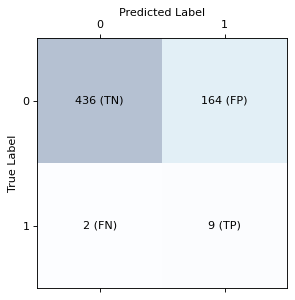

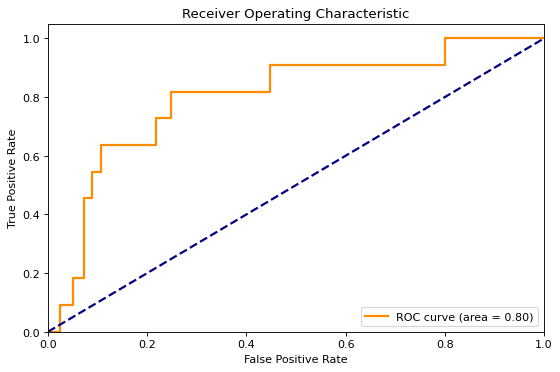

In [16]:
evaluate_model(us_log_rs, X_test_encoded, y_test)

---
### 2. Over-Sampling

In [17]:
from imblearn.over_sampling import RandomOverSampler

log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),'model__class_weight': [None, "balanced"]}

os_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

os_log_rs.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomOverSampler(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000016AC46755B0>,
                                        'model__class_weight': [None,
                                                                'balanced']},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

In [18]:
os_log_rs_df = pd.DataFrame(os_log_rs.cv_results_)
os_log_rs_df.sort_values("mean_test_recall", ascending=False)[["param_model__C", 
                                                               "mean_test_recall", 
                                                               "std_test_recall"]].head()

,param_model__C,mean_test_recall,std_test_recall
0,5.620905,0.725238,0.103297
44,0.220444,0.725238,0.103297
32,61.146821,0.725238,0.103297
33,0.048236,0.725238,0.103297
34,1450.823665,0.725238,0.103297


Best Parameters: {'model__C': 5.620904786086305, 'model__class_weight': None}
Highest Recall: 0.7252380952380952
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87       600
         1.0       0.06      0.73      0.10        11

    accuracy                           0.77       611
   macro avg       0.52      0.75      0.49       611
weighted avg       0.98      0.77      0.85       611



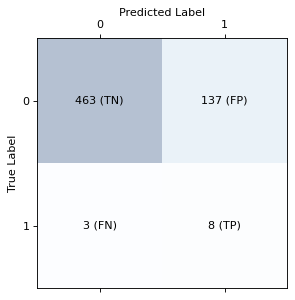

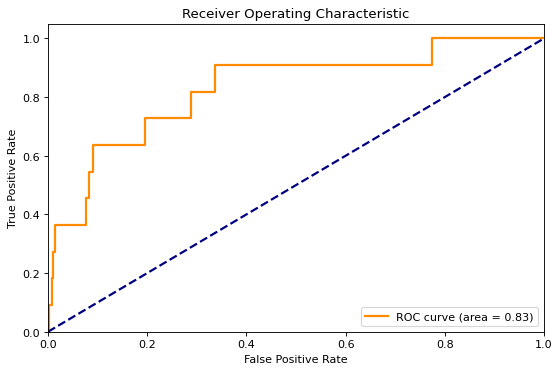

In [19]:
evaluate_model(os_log_rs, X_test_encoded, y_test)


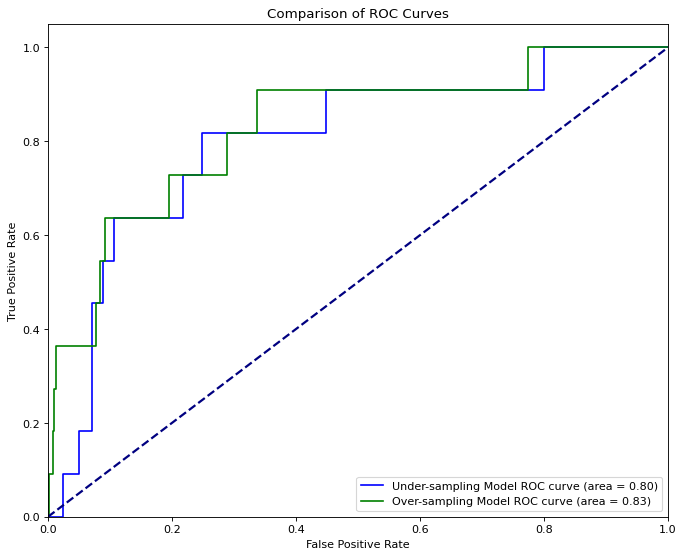

In [20]:

# 假设 `us_log_rs` 和 `os_log_rs` 是你的两个模型实例，`X_test_encoded` 和 `y_test` 是测试数据
plot_roc_curves(us_log_rs, os_log_rs, X_test_encoded, y_test, model1_name='Under-sampling Model', model2_name='Over-sampling Model')


这个图展示了两个不同模型的接收者操作特征（ROC）曲线，它们被用来评估分类器的性能。ROC曲线是通过在不同的阈值设置下绘制真阳性率（True Positive Rate, TPR）和假阳性率（False Positive Rate, FPR）来生成的。图中包含了两条曲线：

1. **蓝色曲线**：代表采用欠采样策略的模型。其AUC（Area Under Curve）值为0.80，表明模型有较好的分类能力，但在某些点的性能下降，显示出一些"阶梯"效应。

2. **绿色曲线**：代表采用过采样策略的模型。其AUC值为0.83，略高于蓝色曲线的AUC值，这表明过采样模型整体上可能比欠采样模型具有更好的分类性能。

几点分析：

- **AUC值**：两个模型的AUC值都超过了0.5（对应于无信息分类器的AUC），这表明两个模型都具有区分两个类别（通常是正类和负类）的能力。AUC值越接近1.0，模型的性能通常认为越好。

- **曲线形状**：理想的ROC曲线会向左上角拉紧，意味着以更少的FPR获得更高的TPR。这里的曲线表明在某些阈值下，两个模型都能够以较低的FPR实现较高的TPR，但也存在一些阈值，其中模型的性能增加不明显（曲线出现平台）。

- **模型选择**：在选择模型时，除了比较AUC值之外，还可能需要考虑其他业务或实际操作中的因素，如模型的可解释性、训练成本、预测时间等。

- **数据不平衡处理**：图中反映了处理不平衡数据集时两种不同策略（欠采样和过采样）的效果。虽然过采样模型在AUC值上略胜一筹，但是实际选择时还需考虑到数据的具体特征以及模型对少数类的识别能力。

总的来说，两个模型的性能相近，但过采样策略的模型表现略好。然而，这种差异是否统计显著以及模型是否满足实际应用需求还需要更深入的分析。在做出最终决策之前，可能还需要考虑成本效益分析、错误类型的严重性（假阳性对比假阴性的代价），以及在不同的操作点上模型的性能。

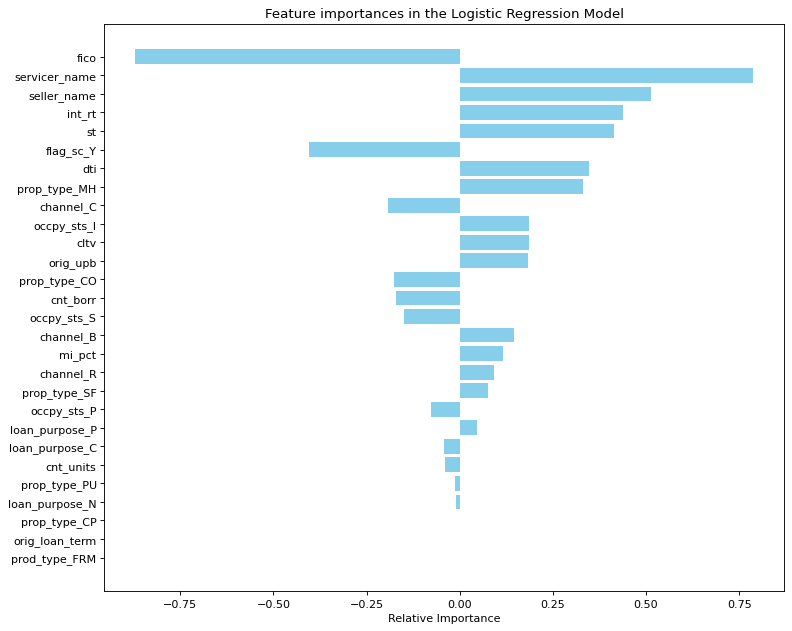

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# 获取最佳估计器并其系数
best_model = us_log_rs.best_estimator_.named_steps['model']
coefficients = best_model.coef_.flatten()

# 特征名称 - 假设你的特征矩阵是pandas DataFrame格式
feature_names = np.array(X_train_encoded.columns)  # 替换为实际特征名称

# 可视化特征的重要性
plt.figure(figsize=(10, 8))
indices = np.argsort(np.abs(coefficients))  # 使用绝对值对系数排序以显示最重要的特征
plt.title("Feature importances in the Logistic Regression Model")
plt.barh(range(len(indices)), coefficients[indices], color='skyblue', align='center')  # 设置颜色为淡蓝色
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域
plt.show()


The horizontal bar chart displays the relative importance of various features in a Logistic Regression Model. Each bar represents a feature used in the model, and the length of the bar indicates the magnitude of the feature's coefficient
Positive values (to the right) suggest a positive relationship with the target variable. Conversely, negative values (to the left) indicate a negative relationship.

The features at the top with longer bars, such as `fico`, `servicer_name`, and `seller_name`, are the most significant predictors in the model, implying that they have the most substantial impact on the outcome. On the other hand, features at the bottom like `orig_loan_term` and `prod_type_FRM` appear to have a minimal influence on the model's predictions.